# $B$ decay after neutrino decoupling (Case 1)
_______

### 1) Computing cosmological quantities

- Definition of units and parameters:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, dblquad
from sympy.solvers import solve
from sympy import Symbol, im
from scipy.special import zeta
from scipy.integrate import odeint
import pandas as pd
from tqdm import tqdm

# Useful for ploting, latex output is turned of
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "monospace",
    "font.monospace": 'Computer Modern'})
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# UNITS
GeV = pow(10,9) # eV
m = 1/(1.9733*pow(10,-16))*pow(GeV,-1)
kg = 1/1.7827*pow(10,27)*GeV
s = (1/6.5823)*pow(10,25)*pow(GeV,-1)
km = pow(10,3)*m
pc = 3.0857*pow(10,16)*m
Mpc = pow(10,6)*pc
K = 8.621738*pow(10,-5) #eV

# Plank mass
mpl = 1.2209*pow(10,19)*GeV 

# LambaCDM parameters
H0 = 67.4*km/s/Mpc # Hubble parameter
w_r = 2.469*10**(-5) # Amendola pag 15
Om = 0.315 # Omega_matter
h = 67.4/100 # reduced hubble parameter
Or = w_r/(h**2) # Omega_radiation
Ol = 1. - Or - Om # Omega_Lambda

# Hubble parameter evolution
def H(a):
    return H0*np.sqrt(abs(Om*pow(a,-3)+Or*pow(a,-4)+Ol))

- Grid of scale factor:

In [2]:
# Scale factor grid
var_a_len = 1000
a_initial_power = -20
a_final_power = 0
var_a = np.logspace(a_initial_power, a_final_power, base=10, num=var_a_len)


# Computing the age of the universe as a function of the scale factor
def axH(a):
    return 1/(a*H(a))
def t(a):
    quadrature = quad(axH,0,a)
    return quadrature[0]

- Computing cosmological background

In [3]:
# Early universe relations
def trad(T):
    g_star = 109.75
    return 0.301*pow(g_star,-0.5)*mpl/pow(T,2)

def Trad_t(t):
    g_star = 109.75
    return pow(0.301*pow(g_star,-0.5)*mpl/t,0.5)

df = pd.DataFrame([x for x in range(len(var_a))], columns=['ind'])

df['a'] = var_a
df['t'] = [t(a) for a in var_a]
df['T'] = Trad_t(df['t'][0])*df['a'][0]/df['a']
df['H'] = H(df['a'])

- Solving the value of the chemical potential across the evolution of the universe

In [4]:
# Fixed parameters
mf = 0.1 # neutrino bounds
gn = 2 # Neutrino internal degrees of freedom
n0 = 339.5*pow(pow(10,-2)*m,-3) # Current number density of neutrinos
dif_c0 = pow(10,-9)*n0 # current value of neutrino assymetry

def solving_mu(a):
    x = Symbol('x')
    F = gn*pow(Trad_t(t(a)),3)/(6*pow(np.pi,2))*(pow(np.pi,2)*x/Trad_t(t(a)) + pow(x/Trad_t(t(a)),3)) - dif_c0*pow(a,-3)
    if im(solve(F,x)[0])!=0:
        print('OJO, imaginary root')
    return float(solve(F,x)[0])

mus = [solving_mu(x) for x in var_a]
df['mu'] = mus
df.to_csv('cosmo.csv')
#df = pd.read_csv('cosmo.csv',header=0,index_col=0)

----

### 2) Computing rates

- Now fix the values of the parameters and compute rates

In [5]:
# Parameters of our model
g = pow(10,-7)
MB = pow(10,5)

In [6]:
df_gMB = df.copy()

# Commoving fermionic charge 
rho_c = -g*dif_c0

# Antifermion number density
df_gMB['n_fbar'] = 3/4*zeta(3)/pow(np.pi,2)*gn*pow(df_gMB['T'],3)

# Assymetry number density
df_gMB['n_f-n_fbar'] = dif_c0*pow(df['a'],-3)

# Fermion number density
df_gMB['n_f'] = df_gMB['n_f-n_fbar'] + df_gMB['n_fbar']

# Rate of decays of B particles
df_gMB['Gamma_B'] = pow(g,2)*MB/(48*np.pi)*(1+2*pow(mf/MB,2))
    # If Gamma_B is negative we impose it to be nan (no physical sense)
df_gMB['Gamma_B'] = np.array(df_gMB['Gamma_B'])*(df_gMB['Gamma_B']>0)

# Rate of production of B by annihilation of f f_bar
df_gMB['Sigma_eff'] = (gn*pow(g,2)/(96*np.pi)*MB/(np.exp((MB/2-df['mu'])/df['T'])+1)*
                       (1+2*pow(mf/MB,2)))

# Relative velocity between fermion and antifermion in the CM system
df_gMB['v_rel'] = 8

# Rate of f fbar scattering with B as a mediator
df_gMB['Gamma_ann_long'] = pow(g,4)*pow(df_gMB['T'],2)/pow(MB,4)*df_gMB['n_f']*df_gMB['v_rel']
df_gMB['Gamma_ann_long'] = df_gMB.Gamma_ann_long.astype(float)
df_gMB['Gamma_ann_trans'] = pow(g,4)*pow(df_gMB['T'],-2)*df_gMB['n_f']*df_gMB['v_rel']

T_chiral = 100*pow(10,9) #eV , Chiral symmetry recovery
nearest_index = (np.abs(df_gMB['T']-T_chiral)).idxmin()
gamma_transition = (df_gMB['Gamma_ann_long'] + df_gMB['Gamma_ann_trans']).iloc[nearest_index]

df_gMB['Gamma_ann'] = ((df_gMB['Gamma_ann_long'] + df_gMB['Gamma_ann_trans'])*(df_gMB['T']<T_chiral) + 
                       (df_gMB['Gamma_ann_trans'] + gamma_transition)*(df_gMB['T']>T_chiral))

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


- Defining important temperatures

In [7]:
T_MB = MB

T_dec = 1.5*pow(10,6)

T_elepos = 0.8*pow(10,6)

T_chiral = pow(10,11)

- Computing $\Gamma_{f\bar{f}\rightarrow B}$, which needs from computing two integrals

In [8]:
# Corrective scale
scale = pow(10,-30)
Gamma_f_per_volume_unit = np.zeros(var_a_len)
gB = 3

def gamma_f_integrand(E1, E2, T, mu):
    
    E_f = (E1+E2)/2
    E_fbar = (E1-E2)/2
    p_f = np.sqrt(pow(E_f,2)-pow(mf,2))
    p_fbar = np.sqrt(pow(E_fbar,2)-pow(mf,2))
    f0_f = 1/(np.exp((p_f-mu)/T)+1)
    f0_fbar = 1/(np.exp((p_fbar+mu)/T)+1)
    constant = gn*gn*pow(2*np.pi,-3)*pow(g,2)/3*pow(MB,2)*(1-2*pow(mf/MB,2))/8
    
    return (constant*f0_f*f0_fbar)*scale

for idx in tqdm(range(var_a_len)):
    df_idx = df_gMB[df_gMB.ind == idx]
    a = float(df_idx['a'])
    T = float(df_idx['T'])
    mu = float(df_idx['mu'])
    n_f = float(df_idx['n_f'])
    n_fbar = float(df_idx['n_fbar'])
    
    Gamma_f_per_volume_unit[idx] = float(dblquad(gamma_f_integrand,
                                                 MB, max(pow(10,3)*T,np.inf),
                                                 lambda E1: -np.sqrt((pow(MB,2)-4*pow(mf,2))*(pow(E1/MB,2)-1)),
                                                 lambda E1: np.sqrt((pow(MB,2)-4*pow(mf,2))*(pow(E1/MB,2)-1)),
                                                 args=(T, mu))[0])/scale
        
# Calculation of the rate of production of B by annihilation of f f_bar
df_gMB['Gamma_f'] = Gamma_f_per_volume_unit*pow(np.sqrt(df['T']**2+MB**2),-3)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/2834056264.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a = float(df_idx['a'])
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/2834056264.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  T = float(df_idx['T'])
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/2834056264.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_idx['mu'])
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/2834056264.py:23: FutureWarning: Calling float on a single element Series is deprecated and will raise a

- Finding T at which B decouples (leaves equilibrium with radiation fluid)

In [9]:
# Finding the temperature at which B enters equilibrium with radiation fluid
idx_Beq = (np.abs(df_gMB['Gamma_ann']-df_gMB['H'])/df_gMB['Gamma_ann']).idxmin()
T_Beq = df['T'].iloc[idx_Beq]

if T_Beq < T_chiral:
    idx_Bdec = idx_Beq
    T_Bdec = T_Beq    
    idx_Beq = (np.abs(df_gMB['Gamma_ann']-df_gMB['H']).iloc[:idx_Beq-100]/df_gMB['Gamma_ann'].iloc[:idx_Beq-100]).idxmin()
    T_Beq = df['T'].iloc[idx_Beq]
else:
    # Finding the temperature at which B leaves it
    idx_Bdec = (np.abs(df_gMB['Gamma_ann']-df_gMB['H']).iloc[idx_Beq+100:]/df_gMB['Gamma_ann'].iloc[idx_Beq+100:]).idxmin()
    T_Bdec = df['T'].iloc[idx_Bdec]

T_Bdec = T_Beq
idx_Bdec = idx_Beq

T_Beq = df['T'][0]
idx_Beq = 0

a_Bdec = df['a'].iloc[idx_Bdec]
a_Beq = df['a'].iloc[idx_Beq]

print('Temperature at the decay/decoupling:',T_Bdec*10**(-9),'GeV')
print('corresponds to g_*=',10)

Temperature at the decay/decoupling: 0.009699078394853846 GeV
corresponds to g_*= 10


- Finding the temperature at which B becomes completely unstable (it rapidly decays)

In [10]:
idx_Bay = (np.abs(df_gMB['Gamma_B']-df_gMB['H'])/df_gMB['Gamma_B']).idxmin()
T_Bay = df['T'].iloc[idx_Bay]
a_Bay = df['a'].iloc[idx_Bay]

- Plotting

g=1e-07, M_B=100000 eV


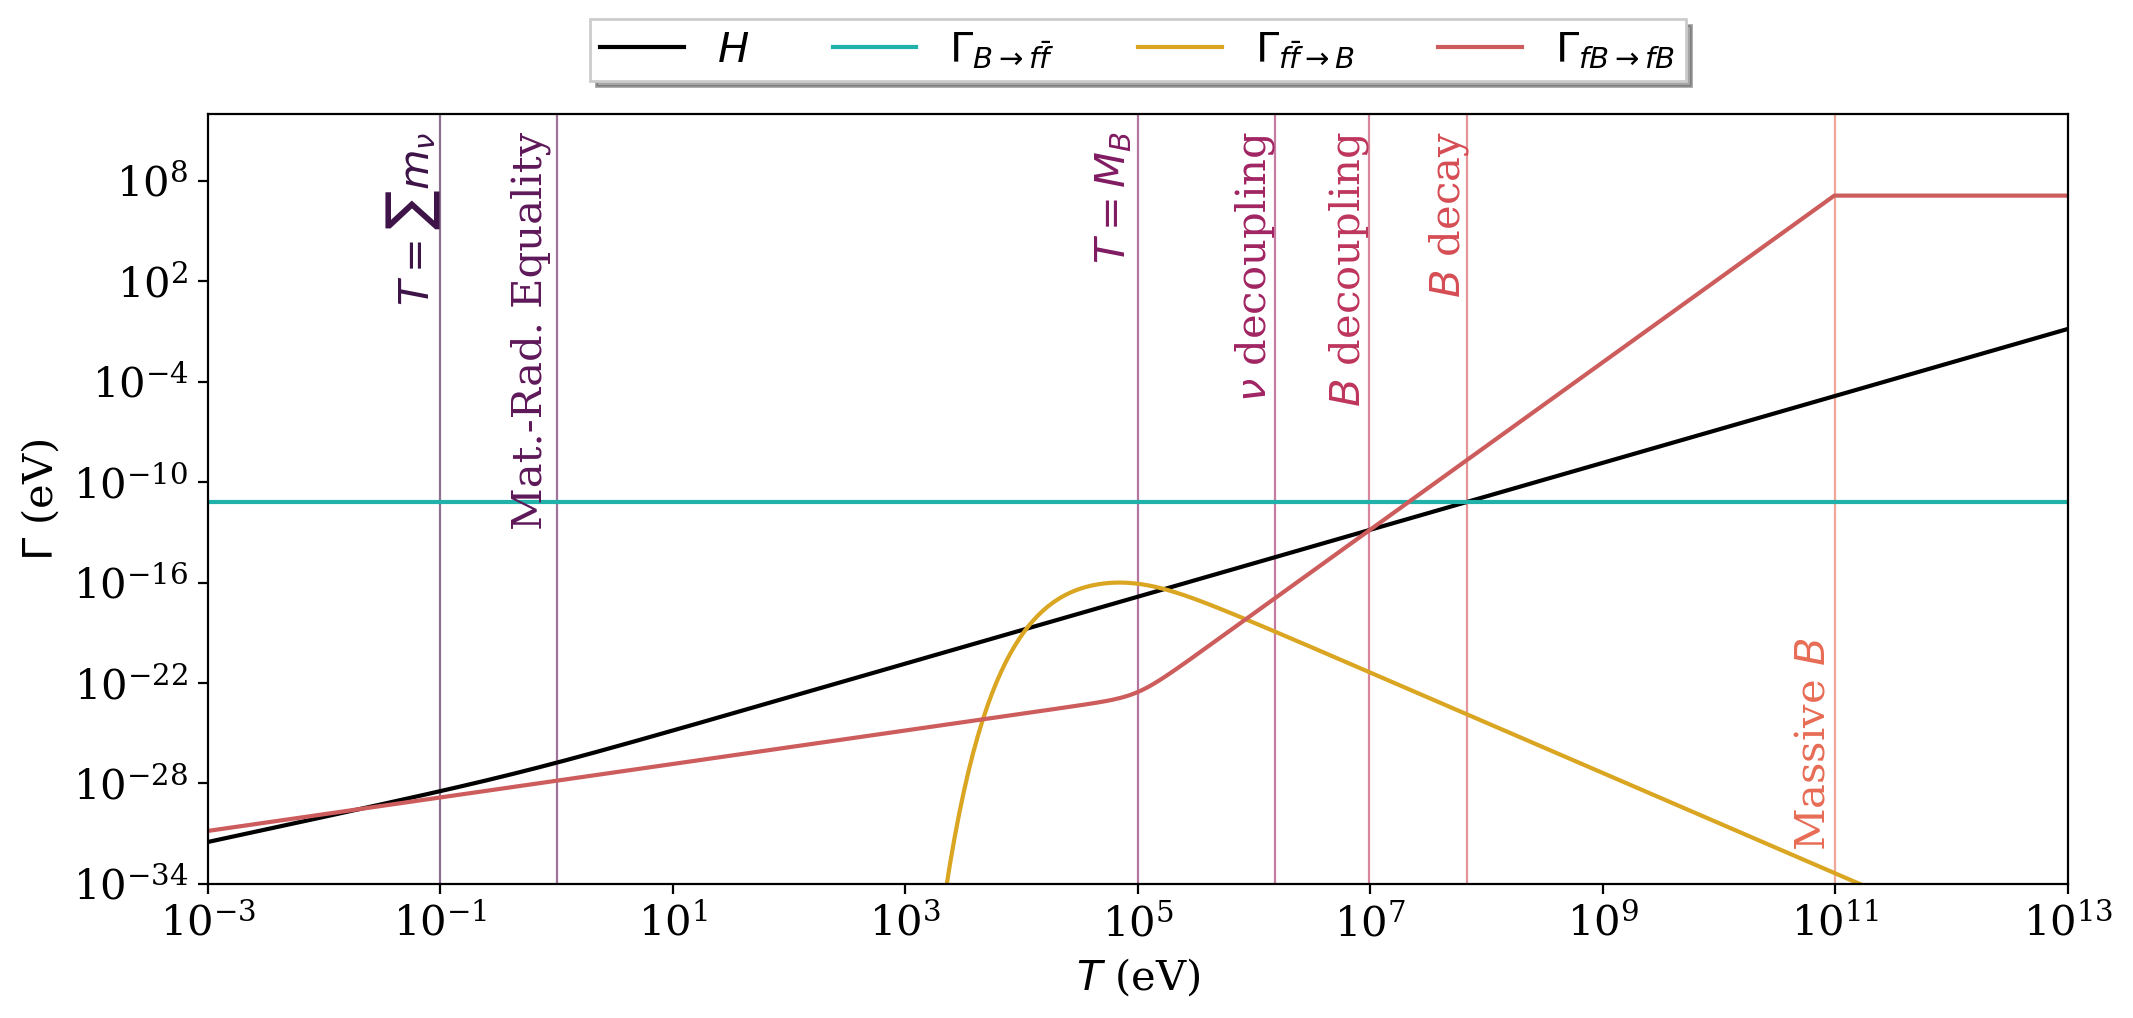

In [11]:
import colormaps as cmaps
from cycler import cycler

fig = plt.figure(figsize=(12,5))
num_colors = 5
colors = [cmaps.precip_diff_12lev(i) for i in range(20)]
colors_curves = colors
plt.rcParams["axes.prop_cycle"] = cycler(color=colors_curves)

colors = [cmaps.matter(i) for i in range(250)][::-1][5::25]

FS = 15
alpha = 1
alphal = 0.6
lw = 0.8

plt.vlines(mf,0,pow(10,20),colors=colors[0],linestyles='-', alpha=alphal, lw=lw)
plt.text(mf/3, 10**11, '$T=\sum m_\\nu$', fontsize=FS, rotation=90, color=colors[0], alpha=alpha, verticalalignment='top')
plt.vlines(pow(10,0),0,pow(10,20),colors=colors[1],linestyles='-', alpha=alphal, lw=lw)
plt.text(pow(10,0)/2.5, 10**11, 'Mat.-Rad. Equality', fontsize=FS, rotation=90, color=colors[1], alpha=alpha, verticalalignment='top')
plt.vlines(MB,0,pow(10,20),colors=colors[2],linestyles='-', alpha=alphal, lw=lw)
plt.text(MB/2.4, 10**11, '$T=M_B$', fontsize=FS, rotation=90, color=colors[2], alpha=alpha, verticalalignment='top')
plt.vlines(T_Bay,0,pow(10,20),colors=colors[5],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_Bay/2.2, 10**11, '$B$ decay', fontsize=FS, rotation=90, color=colors[5], alpha=alpha, verticalalignment='top')
plt.vlines(T_dec,0,pow(10,20),colors=colors[3],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_dec/2.3, 10**11, '$\\nu$ decoupling', fontsize=FS, rotation=90, color=colors[3], alpha=alpha, verticalalignment='top')
plt.vlines(T_Bdec,0,pow(10,20),colors=colors[4],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_Bdec/2.3, 10**11, '$B$ decoupling', fontsize=FS, rotation=90, color=colors[4], alpha=alpha, verticalalignment='top')
plt.vlines(T_chiral,0,pow(10,20),colors=colors[6],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_chiral/2.3, 10**(-32), 'Massive $B$', fontsize=FS, rotation=90, color=colors[6], alpha=alpha, verticalalignment='bottom')
#plt.vlines(T_Beq,0,pow(10,20),colors=colors[7],linestyles='-', alpha=alphal, lw=lw)
#plt.text(T_Beq/2.3, 10**(-33), '$B$ enters equil.', fontsize=FS, rotation=90, color=colors[7], alpha=alpha, verticalalignment='bottom')
plt.ylabel('$\Gamma$ (eV)')
plt.xlabel('$T$ (eV)')
plt.ylim(10**(-34),10**12)
plt.xlim(10**(-3),10**13)
print('g='+str(g)+', M_B='+str(MB)+' eV')


plt.plot(df['T'],df['H'],'-',label = '$H$',color='Black')
plt.plot(df['T'],df_gMB['Gamma_B'],'-', label = '$\Gamma_{B \\rightarrow f\\bar{f}}$', color='lightseagreen')
plt.plot(df['T'], df_gMB['Gamma_f'], ls='-',label = '$\Gamma_{f\\bar{f}\\rightarrow B}$', color='goldenrod')
plt.plot(df['T'],df_gMB['Gamma_ann'], ls ='-', label = '$\Gamma_{fB\\rightarrow fB}$', color='indianred')



plt.loglog()
plt.legend(bbox_to_anchor=(0.5,1.15), loc='upper center',ncols=4, fancybox=0, framealpha=1, shadow=1, borderpad=0.25)

#plt.tight_layout()
fig.savefig('images/early_decoupling.pdf',bbox_inches='tight')

plt.show()

_______

### Computing energy densities
- Computing $\rho_B$ classical

In [12]:
# Background component
df_gMB['rho_B_back'] = pow(g/MB*dif_c0,2)*pow(df_gMB['a'],-6)

- Computing $\rho_B$ themal

In [13]:
# Particle component of the B energy density

# equilibrium
df_gMB['rho_B_part'] = ((pow(np.pi,2)/30*2*pow(df['T'],4))*(df['T']>=T_chiral)*(df['T']<=T_Beq) + 
                        (pow(np.pi,2)/30*3*pow(df['T'],4))*(df['T']>=T_Bdec)*(df['T']<T_chiral))


# decay, we must inject this energy to other relativistic components
rho_Bay = df_gMB['rho_B_part'].iloc[idx_Bdec] # decoupling and decay coincide

# Pre-equilibrium
df_gMB['rho_B_part'] = (df_gMB['rho_B_part'] +
                        df_gMB['rho_B_part'].iloc[idx_Beq]*pow(a_Beq/df['a'],4)*(df['T']>T_Beq))

# Here we should distinguish if this process happens before or after neutrino decoupling

# For decay before the decoupling of fermions
T_before = df['T'].iloc[idx_Bdec]
gstar = 10
T_after = pow(pow(T_before,4)+rho_Bay/(pow(np.pi,2)/30*gstar),1/4)
T_rise_ratio = T_after/T_before

- Energy density, pressure and number density of Bs. Keeping track of changes in photon temperature

In [14]:
EB_list = np.zeros(var_a_len)
PB_list = np.zeros(var_a_len)
nB_list = np.zeros(var_a_len)

T_gamma = np.zeros(var_a_len)

# Energy density of Bs
def EB_integrand(x, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    return (pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p)-1,-1))*scale

# Pressure of Bs
def PB_integrand(x, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    return (pow(pow(x,2)-pow(beta,2),3/2)*pow(np.exp(p)-1,-1))*scale

# Number density of Bs
def nB_integrand(x, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    return (x*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p)-1,-1))*scale

for idx in tqdm(range(var_a_len)):
    df_idx = df_gMB[df_gMB.ind == idx]
    T = float(df_idx['T'])
    T_orig = T
    T_gamma[idx] = T
    decay = 1.
    
    if T>T_chiral:
        gB = 2
        
    elif T<T_Bdec:
        T_gamma[idx] = T*T_rise_ratio #Injection of energy to the radiation
        # (because the decoupling coincides with the decay, its the decay the one that injects)
        if T_orig<T_Bay:
            EB_list[idx] = 0
            PB_list[idx] = 0
            nB_list[idx] = 0
            decay = 0
            
    beta = mf/T
    
    EB_list[idx] = decay*gB*pow(T,4)/(2*pow(np.pi,2))*float(quad(EB_integrand, beta, np.inf, args=(beta))[0])/scale
    PB_list[idx] = decay*gB*pow(T,4)/(6*pow(np.pi,2))*float(quad(PB_integrand, beta, np.inf, args=(beta))[0])/scale
    nB_list[idx] = decay*gB*pow(T,3)/(2*pow(np.pi,2))*float(quad(nB_integrand, beta, np.inf, args=(beta))[0])/scale
    
    gB = 3
  
df_gMB['rho_B'] = EB_list
df_gMB['P_B'] = PB_list
df_gMB['nB_general'] = nB_list

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/1610347769.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  T = float(df_idx['T'])
 93%|███████████████████████████████████▏  | 926/1000 [00:00<00:00, 3129.06it/s]/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/1610347769.py:10: RuntimeWarning: overflow encountered in exp
  return (pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p)-1,-1))*scale
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/1610347769.py:15: RuntimeWarning: overflow encountered in exp
  return (pow(pow(x,2)-pow(beta,2),3/2)*pow(np.exp(p)-1,-1))*scale
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/1610347769.py:20: RuntimeWarning: overflow encountered in exp
  return (x*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p)-1,-1))*scale


- Same for neutrinos + antineutrinos

In [15]:
Enu_list = np.zeros(var_a_len)
Pnu_list = np.zeros(var_a_len)
nnu_list = np.zeros(var_a_len)

# Nu-nubar energy density
def Enu_integrand(x, alpha, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    particle = pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p-alpha)+1,-1)
    antiparticle = pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p+alpha)+1,-1)
    return (particle+antiparticle)*scale

# Nu-nubar pressure
def Pnu_integrand(x, alpha, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    particle = pow(pow(x,2)-pow(beta,2),3/2)*pow(np.exp(p-alpha)+1,-1)
    antiparticle = pow(pow(x,2)-pow(beta,2),3/2)*pow(np.exp(p+alpha)+1,-1)
    return (particle + antiparticle)*scale

# Nu-nubar number density
def nnu_integrand(x, alpha, beta):
    p = np.sqrt(pow(x,2) - pow(beta,2)) # momentum divided by temperature
    particle = x*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p-alpha)+1,-1)
    antiparticle = x*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p+alpha)+1,-1)
    return (particle+antiparticle)*scale

for idx in tqdm(range(var_a_len)):
    df_idx = df_gMB[df_gMB.ind == idx]
    T = T_gamma[idx]
    T_orig = T
    
    if T<T_elepos:
        T_gamma[idx] = T*pow(4/11,-1/3) # photons get heated up by e+e- annihilation

    mu = float(df_idx['mu'])
    alpha = mu/T
    beta = mf/T
    
    Enu_list[idx] = gn*pow(T,4)/(2*pow(np.pi,2))*float(quad(Enu_integrand, beta, np.inf, args=(alpha, beta))[0])/scale
    Pnu_list[idx] = gn*pow(T,4)/(6*pow(np.pi,2))*float(quad(Pnu_integrand, beta, np.inf, args=(alpha, beta))[0])/scale
    nnu_list[idx] = gn*pow(T,3)/(2*pow(np.pi,2))*float(quad(nnu_integrand, beta, np.inf, args=(alpha, beta))[0])/scale
    
# Total (particle + antiparticle) densities    
df_gMB['rho_f'] = Enu_list
df_gMB['P_f'] = Pnu_list
df_gMB['nf_general'] = nnu_list

# Temperature of the photon fluid
df_gMB['T_gamma'] = T_gamma

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/650066149.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(df_idx['mu'])
 90%|██████████████████████████████████    | 897/1000 [00:00<00:00, 2955.99it/s]/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/650066149.py:8: RuntimeWarning: overflow encountered in exp
  particle = pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p-alpha)+1,-1)
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/650066149.py:9: RuntimeWarning: overflow encountered in exp
  antiparticle = pow(x,2)*np.sqrt(pow(x,2)-pow(beta,2))*pow(np.exp(p+alpha)+1,-1)
/var/folders/d5/hgg8g25s3r5f0yb4ypydg5fc0000gn/T/ipykernel_6216/650066149.py:15: RuntimeWarning: overflow encountered in exp
  particle = pow(pow(x,2)-pow(beta,2),3/2)*pow(np.exp(p-

- Plotting

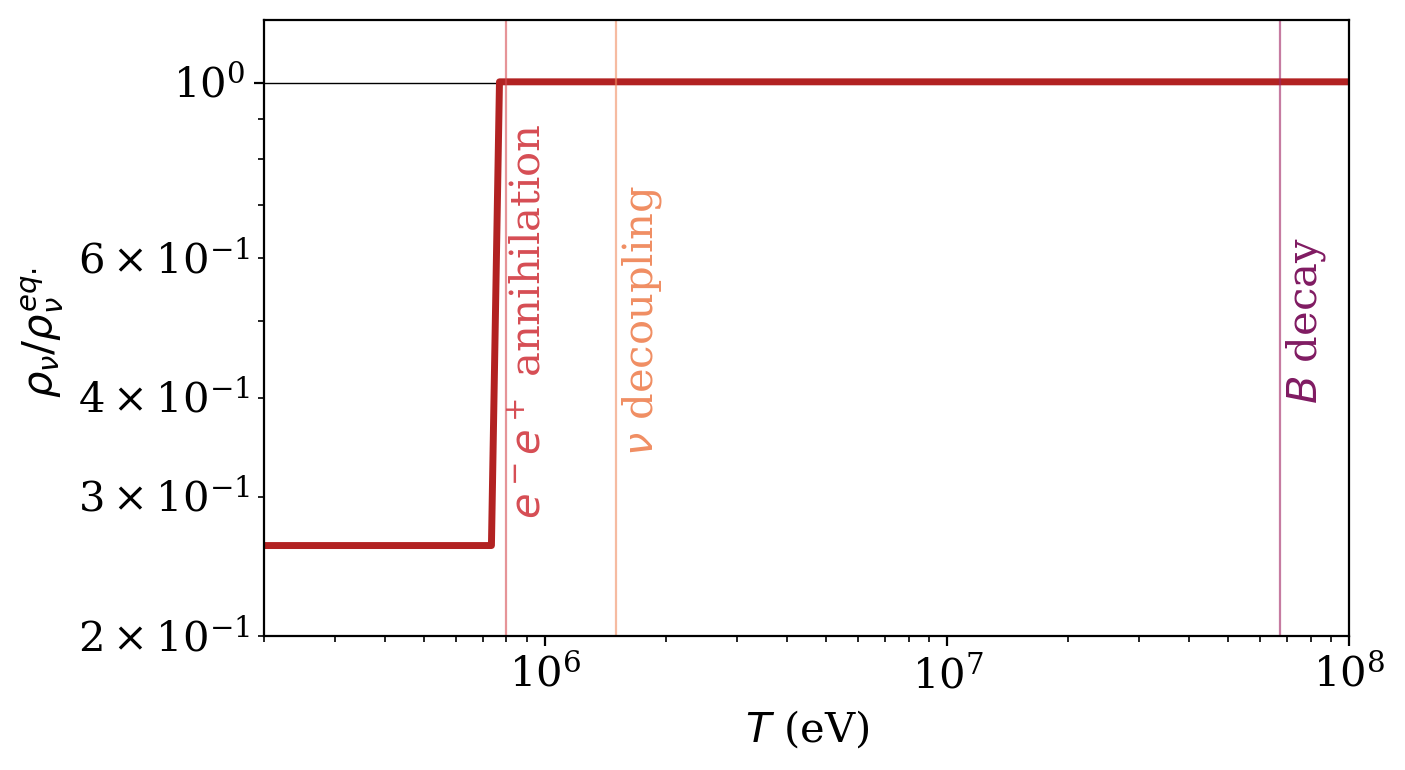

In [16]:
fig = plt.figure(figsize=(7,4))

plt.hlines(1,pow(10,5),pow(10,7),colors='k',linestyles='-',lw=0.5)

plt.plot(df['T'], df_gMB['rho_f']/(7/8*pow(np.pi,2)/30*2*gn*pow(T_gamma,4)),'firebrick', lw=2.5)


plt.vlines(T_dec,0,pow(10,20),colors=colors[7],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_dec*1.02, 5*10**-1, '$\\nu$ decoupling', fontsize=FS, rotation=90, color=colors[7], alpha=1, verticalalignment='center')
plt.vlines(T_elepos,0,pow(10,20),colors=colors[5],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_elepos*1.02, 5*10**-1, '$e^- e^+$ annihilation', fontsize=FS, rotation=90, color=colors[5], alpha=1, verticalalignment='center')
plt.vlines(T_Bay,0,pow(10,20),colors=colors[3],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_Bay*1.02, 5*10**-1, '$B$ decay', fontsize=FS, rotation=90, color=colors[2], alpha=1, verticalalignment='center')

plt.loglog()
plt.ylabel('$\\rho_\\nu/\\rho_\\nu^{eq.}$ ')
plt.xlabel('$T$ (eV)')
plt.ylim(0.2,1.2)
plt.xlim(2.*10**5,10**8)
plt.show()

fig.savefig('images/early_dec_rhos.pdf',bbox_inches='tight')

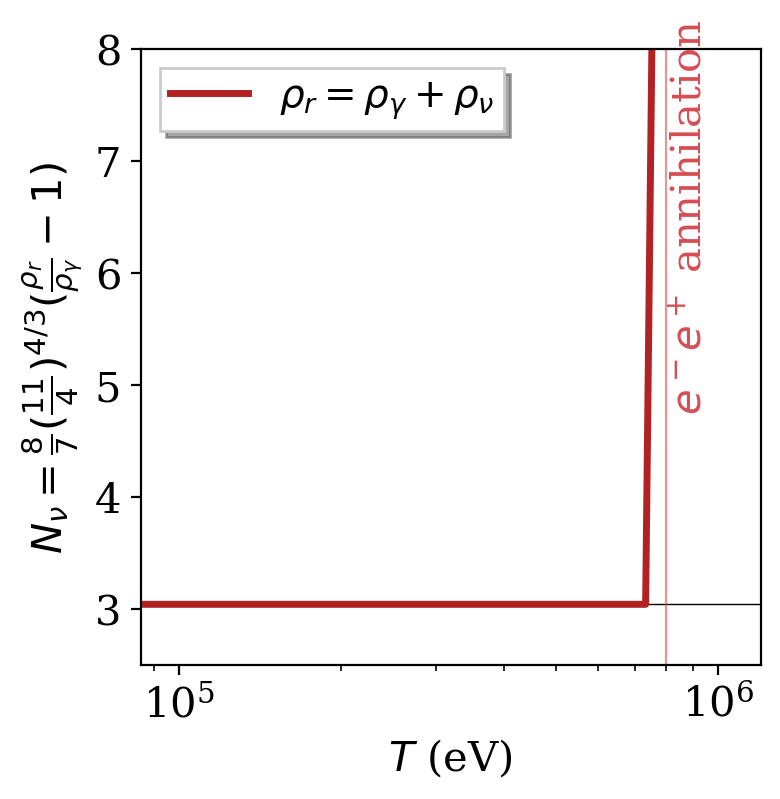

N_eff= 18.22263318953556
PseudoN_eff= 11.617826195847869


In [17]:
fig = plt.figure(figsize=(4,4))

QED_on = 1

plt.hlines(3.04,pow(10,-5),pow(10,7),colors='k',linestyles='-',lw=0.5)

plt.plot(df['T'], QED_on*0.0343 + (8/7*pow(11/4,4/3)*((3/2*df_gMB['rho_f']+df_gMB['rho_B_part'])/(pow(np.pi,2)/30*2*pow(T_gamma,4)))),
         color='firebrick',lw=2.5,label='$\\rho_r = \\rho_\\gamma + \\rho_\\nu$')


plt.vlines(T_elepos,0,pow(10,20),colors=colors[5],linestyles='-', alpha=alphal, lw=lw)
plt.text(T_elepos*1.02, 6.5, '$e^- e^+$ annihilation', fontsize=FS, rotation=90, color=colors[5], alpha=1, verticalalignment='center')


plt.semilogx()
plt.ylim(2.5,8)
plt.xlim(0.85*10**5,1.2*10**6)
plt.ylabel('$N_\\nu$')
plt.ylabel('$N_\\nu = \\frac{8}{7}( \\frac{11}{4} )^{4/3} ( \\frac{\\rho_r}{\\rho_\\gamma} - 1 ) $')
plt.xlabel('$T$ (eV)')
plt.legend(fancybox=0, framealpha=1, shadow=1, borderpad=0.25, fontsize=14)
plt.show()
print('N_eff=',QED_on*0.034 + ((8/7*pow(11/4,4/3)*((3/2*df_gMB['rho_f']+df_gMB['rho_B_part'])/(pow(np.pi,2)/30*2*pow(T_gamma,4))))).iloc[idx_Bay])
print('PseudoN_eff=',QED_on*0.034 + ((8/7*pow(11/4,4/3)*((3/2*df_gMB['rho_f'])/(pow(np.pi,2)/30*2*pow(T_gamma,4))))).iloc[idx_Bay])

fig.savefig('images/early_dec_Nnu.pdf',bbox_inches='tight')

Text(0.5, 0, '$T_\\gamma$ (eV)')

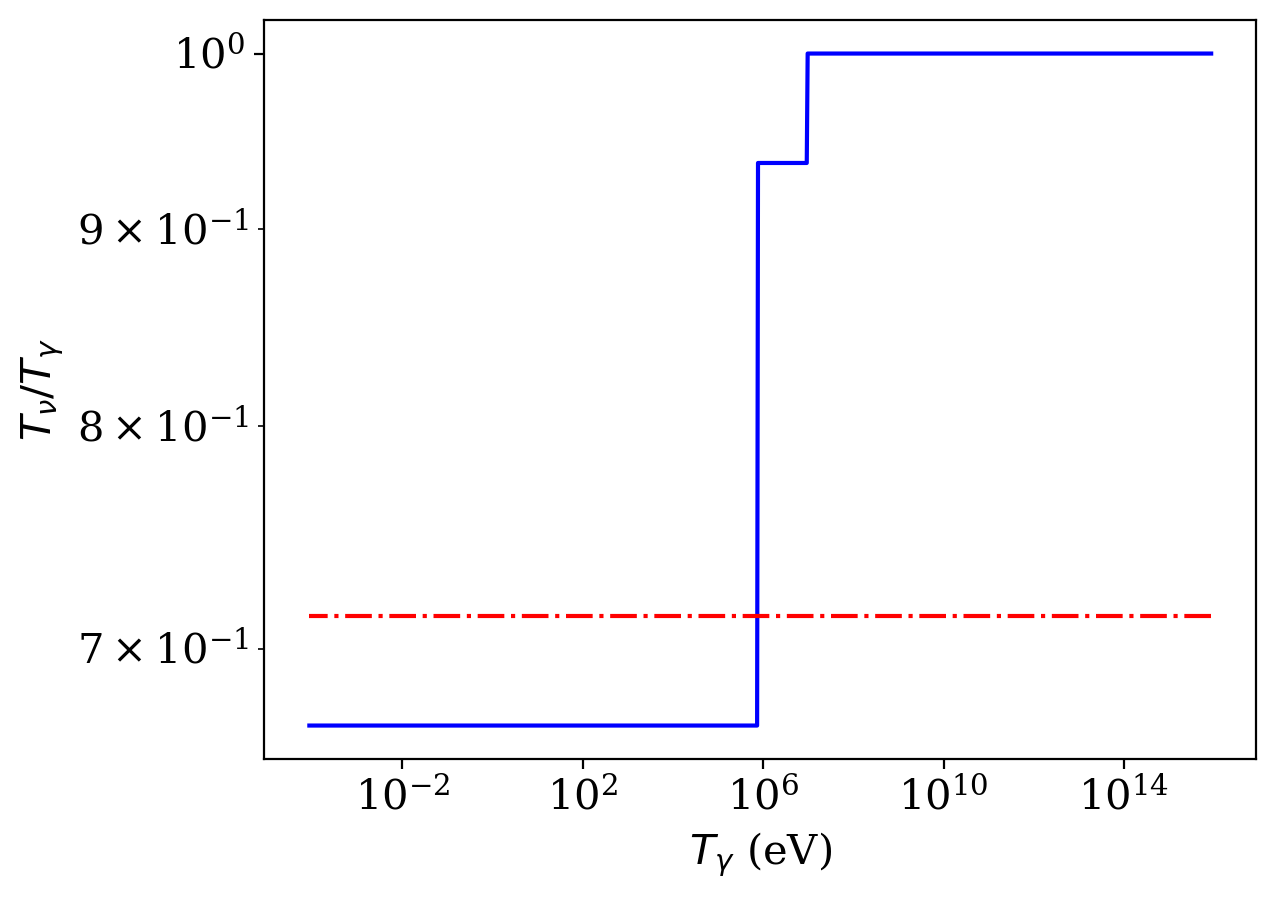

In [18]:
plt.plot(df['T'], df['T']/T_gamma, color='blue')
plt.plot(df['T'], np.ones(var_a_len)*pow(4/11,1/3), '-.', color='red')
plt.loglog()
plt.ylabel('$T_\\nu/T_\gamma$ ')
plt.xlabel('$T_\gamma$ (eV)')

- Equation of state of neutrinos, evolution from radiation to non-relativistic matter

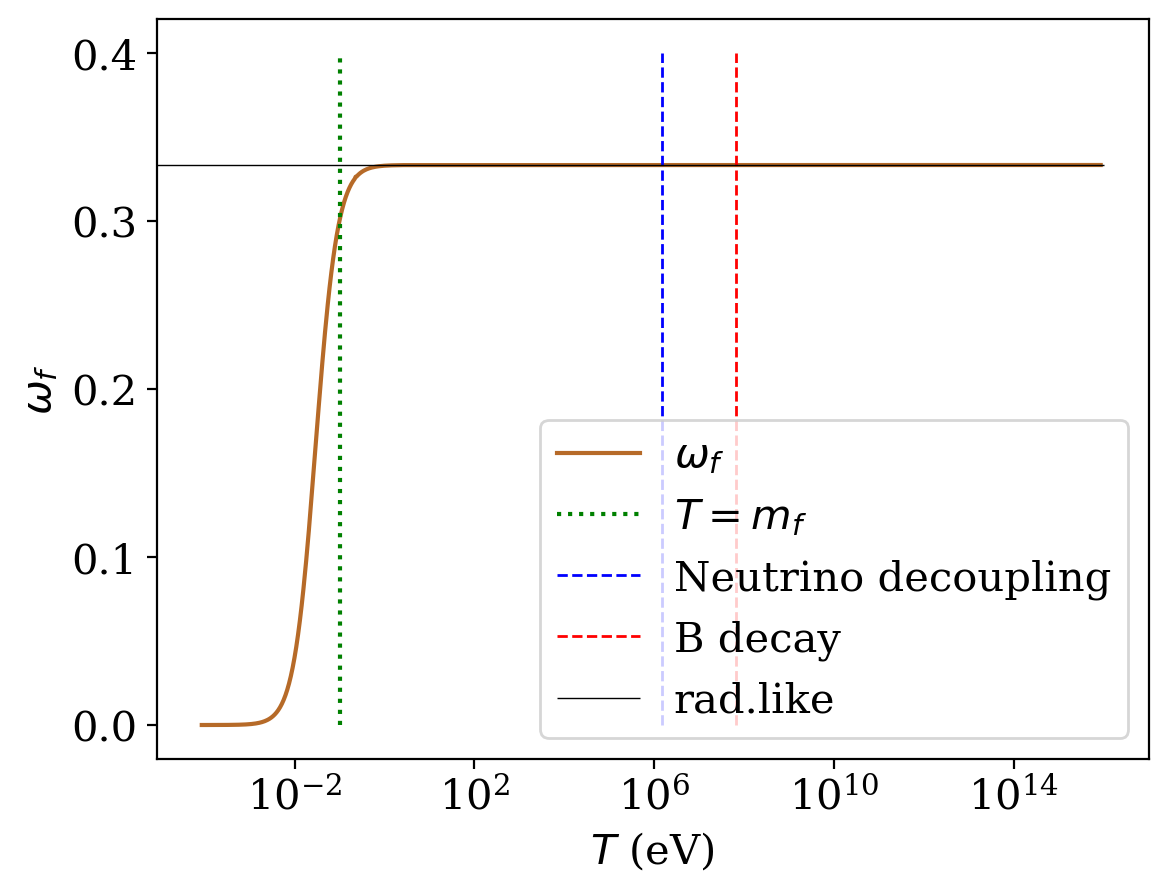

In [19]:
plt.plot(df['T'], df_gMB['P_f']/df_gMB['rho_f'], label='$\\omega_f$')
plt.vlines(mf,0,0.4,colors='green',linestyles='dotted',label='$T=m_f$')
plt.vlines(T_dec,0,0.4,colors='blue',linestyles='dashed',lw=1., label='Neutrino decoupling')
plt.vlines(T_Bay,0,0.4,colors='red',linestyles='dashed',lw=1., label='B decay')
plt.hlines(1/3,0,10**16,colors='k',linestyles='-',lw=0.5, label='rad.like')


plt.semilogx()
plt.ylabel('$\\omega_f$')
plt.xlabel('$T$ (eV)')
plt.legend()

plt.show()

- Energy density comparison of background vs. thermal contributions

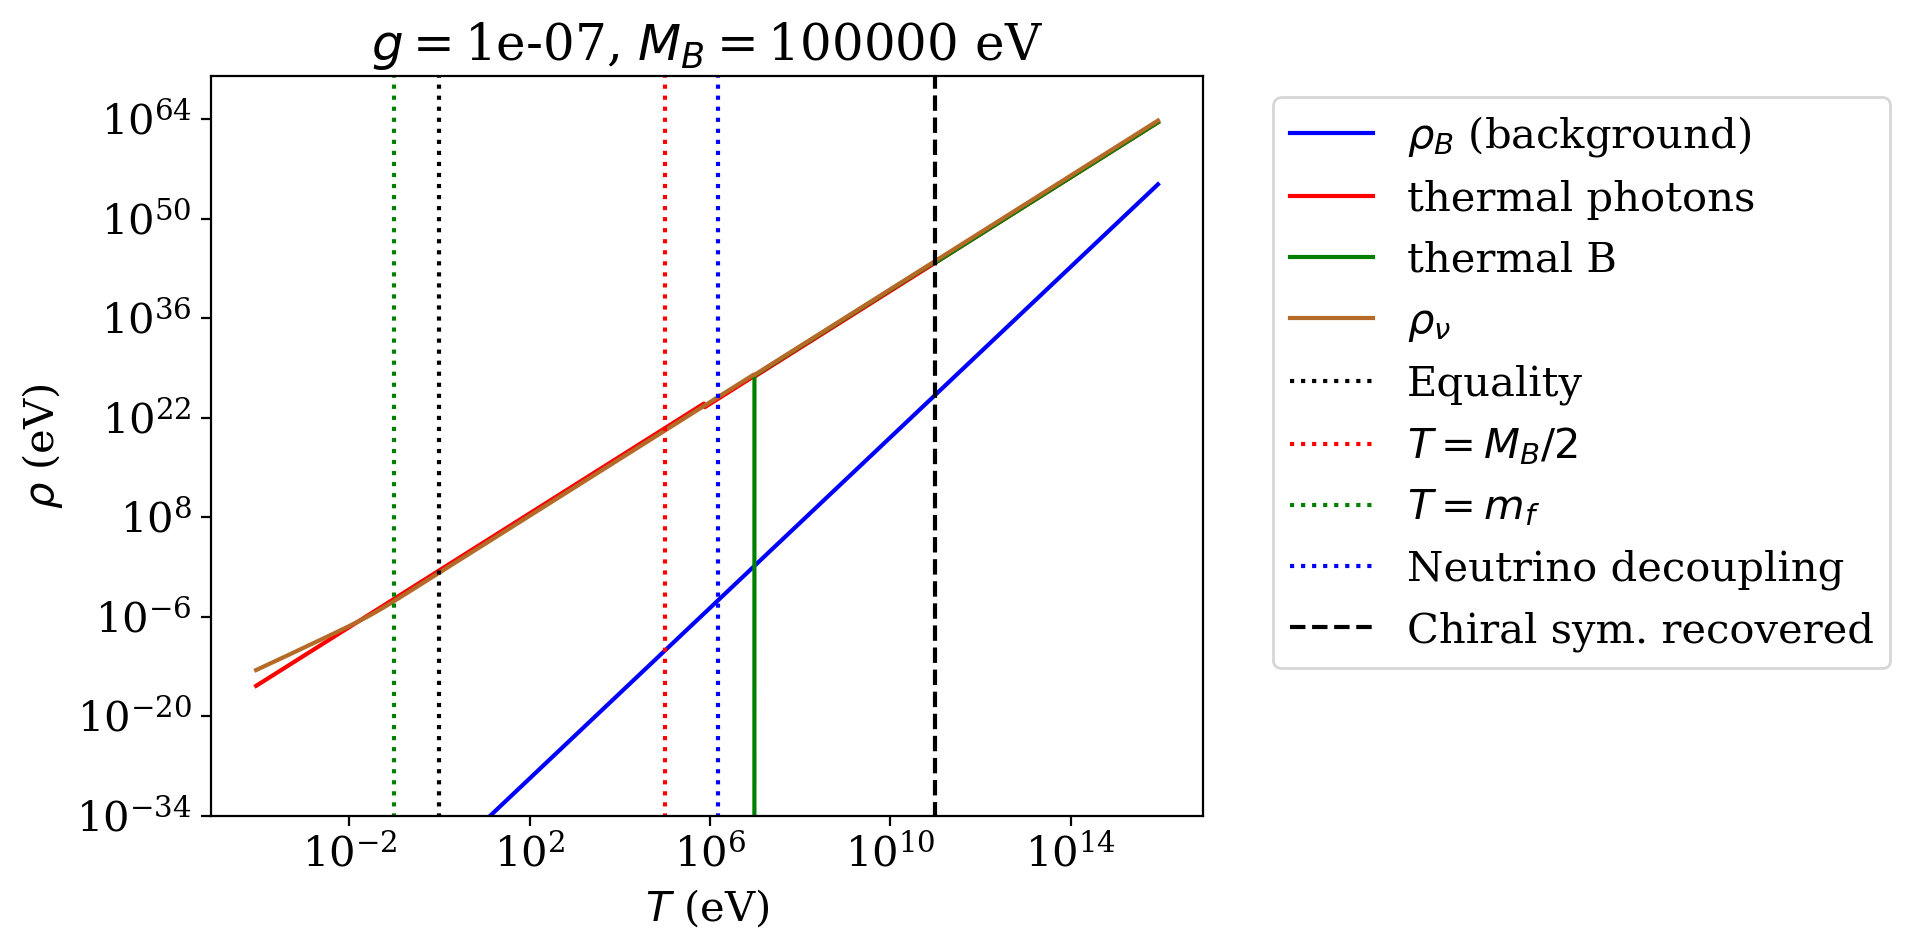

In [20]:
plt.plot(df['T'],df_gMB['rho_B_back'], 'b', label = '$\\rho_B$ (background)')
plt.plot(df['T'], (pow(np.pi,2)/15*pow(T_gamma,4)), 'r', label='thermal photons')
plt.plot(df['T'], df_gMB['rho_B_part'], 'g', label='thermal B')
plt.plot(df['T'], df_gMB['rho_f'], label='$\\rho_{\\nu}$')


plt.vlines(pow(10,0),0,pow(10,70),colors='black',linestyles='dotted',label='Equality')
plt.vlines(T_MB,0,pow(10,70),colors='red',linestyles='dotted',label='$T=M_B/2$')
plt.vlines(mf,0,pow(10,70),colors='green',linestyles='dotted',label='$T=m_f$')
plt.vlines(T_dec,0,pow(10,70),colors='blue',linestyles='dotted',label='Neutrino decoupling')
plt.vlines(T_chiral,0,pow(10,70),colors='black',linestyles='dashed',label='Chiral sym. recovered')
plt.ylabel('$\\rho$ (eV)')
plt.xlabel('$T$ (eV)')
plt.ylim(10**(-34))
plt.title('$g=$'+str(g)+', $M_B=$'+str(MB)+' eV')
plt.loglog()
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

_______